In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable 
from matplotlib.colors import Normalize, to_rgba
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
import socket
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *
from plot_utils import barplot_annotate_brackets

plt.style.use('../sci_style.py')

In [3]:
if socket.gethostname() == 'millerlab-endeavourOS':
    img_save_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/images"
    data_save_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/figure_data"
else:
    img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
    data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

# Load Data

In [4]:
# # session = 'Mary-Anesthesia-20160912-02'
# # session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False
subsample = 1

if socket.gethostname() == 'millerlab-endeavourOS':
    results_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/stability_results_redone/stability_results"
else:
    results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/stability_results_redone/stability_results'

session_list = os.listdir(results_dir)

In [5]:
session_rets = {}
for session in tqdm(session_list):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    session_rets[session] = {}
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    print("loading data...")
    if socket.gethostname() == 'millerlab-endeavourOS':
        all_data_dir = "/home/adameisen/millerdata/data/common/datasets/anesthesia/mat"
    else:
        all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    session_rets[session]['electrode_info'] = electrode_info
    session_rets[session]['session_info'] = session_info
    session_rets[session]['eyes_open'] = eyes_open
    session_rets[session]['eyes_close'] = eyes_close
    session_rets[session]['section_times'] = section_times
    session_rets[session]['sections'] = sections
    
    print("data loaded!")
    print("loading results...")
    norm_dir = "NORMED" if norm else "NOT_NORMED"
    subsample_dir = f"SUBSAMPLE_{subsample}" if "redone" in results_dir else ""
    total = 0
    for area in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir)):
        total += len(os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir, area)))
    
    results_dict = {}
    iterator = tqdm(total=total)
    for area in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir)):
        results_dict[area] = None
        for f in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir, area)):
            if 'redone' in results_dir:
                df = pd.read_pickle(os.path.join(results_dir, session, norm_dir, subsample_dir, area, f))
                df['area'] = area
                df['start_time'] = df['window_start']
                df['end_time'] = df['window_end']
                df['start_ind'] = int(df['window_start']/dt)
                df['end_ind'] = int(df['window_end']/dt)
                df = pd.DataFrame([df])

                if results_dict[area] is None:
                    results_dict[area] = df
                else:
                    results_dict[area] = pd.concat([results_dict[area], df])
            
            else:
                t = float(f.split('_')[0])
                df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_dir, subsample_dir, area, f)))
                if len(df) > 0:
                    df['area'] = area
                    df['start_time'] = t
                    df['end_time'] = t + df.window*dt
                    df['start_ind'] = int(t/dt)
                    df['end_ind'] = int(t/dt) + df.window
    
                    if results_dict[area] is None:
                        results_dict[area] = df
                    else:
                        results_dict[area] = pd.concat([results_dict[area], df])
                else:
                    print(f"{area}/{f} is empty")
            iterator.update()
        results_dict[area] = results_dict[area].sort_values('start_time')
    
    session_rets[session]['results_dict'] = results_dict
    
    print("results loaded!")
    iterator.close()

  0%|          | 0/21 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160105-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4150 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160818-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/1880 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2205 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160902-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2295 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160210-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3245 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160107-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4355 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160206-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3550 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160109-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4055 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160916-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2150 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160912-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2160 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160809-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2355 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160826-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2245 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160113-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3485 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160123-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3880 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160822-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2010 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160914-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2060 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160831-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2060 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3295 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160201-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3385 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160125-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3355 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160121-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3365 [00:00<?, ?it/s]

results loaded!


# Figure 3

## Prediction quality: monkeys split by monkey

In [6]:
figure3_data = {}

In [7]:
split_by_monkey = True
if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
    monkey_sessions = {monkey: [session for session in session_list if monkey in session] for monkey in monkeys}
    session_dicts = {monkey: {session: session_rets[session] for session in monkey_sessions[monkey]} for monkey in monkeys}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
else:
    monkeys = ['Combined']
    monkey_sessions = {'Combined': session_list}
    session_dicts = {'Combined': session_rets}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}

# areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
areas = ['all']

In [8]:
aic_vals = {}
aic_vals_pb = {}
aic_vals_VAR = {}
aic_vals_VAR_small = {}

mse_vals = {}
mse_vals_pb = {}
mse_vals_VAR = {}
mse_vals_VAR_small = {}

iterator = tqdm(total=len(session_list)*len(areas))

for monkey in monkeys:
    aic_vals[monkey] = {}
    aic_vals_pb[monkey] = {}
    aic_vals_VAR[monkey] = {}
    aic_vals_VAR_small[monkey] = {}

    mse_vals[monkey] = {}
    mse_vals_pb[monkey] = {}
    mse_vals_VAR[monkey] = {}
    mse_vals_VAR_small[monkey] = {}
    for area in areas:
        aic_vals[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_pb[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_VAR[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_VAR_small[monkey][area] = np.zeros(num_sessions[monkey])

        mse_vals[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_pb[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_VAR[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_VAR_small[monkey][area] = np.zeros(num_sessions[monkey])
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
        
            aic_vals[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val.mean()
            aic_vals_pb[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_pb.mean()
            aic_vals_VAR[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_VAR.mean()
            aic_vals_VAR_small[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_VAR_small.mean()

            mse_vals[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val.mean()
            mse_vals_pb[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_pb.mean()
            mse_vals_VAR[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_VAR.mean()
            mse_vals_VAR_small[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_VAR_small.mean()

            iterator.update()
iterator.close()

figure3_data['split_by_monkey'] = dict(
    aic_vals=aic_vals,
    aic_vals_pb=aic_vals_pb,
    aic_vals_VAR=aic_vals_VAR,
    aic_vals_VAR_small=aic_vals_VAR_small,
    mse_vals=mse_vals,
    mse_vals_pb=mse_vals_pb,
    mse_vals_VAR=mse_vals_VAR,
    mse_vals_VAR_small=mse_vals_VAR_small
)

  0%|          | 0/21 [00:00<?, ?it/s]

In [9]:
statistical_test = scipy.stats.wilcoxon
# statistical_test = scipy.stats.ttest_ind

In [10]:
model_colors = ['#BBBBBB', 'teal', 'darkturquoise', 'coral']

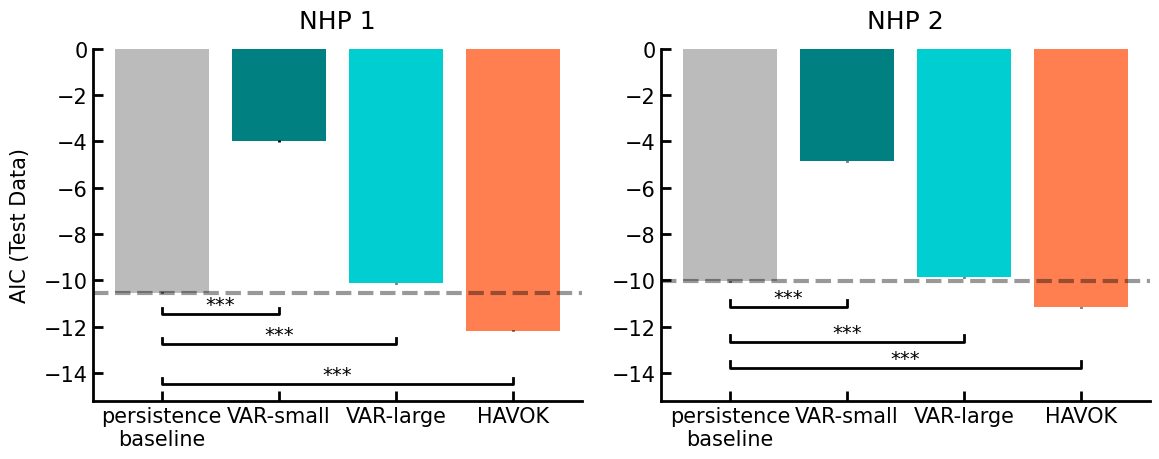

In [11]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
        ax = axs[i]   
        # bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-large', 'HAVOK']
        bars = [0, 1, 2, 3]
        # heights = np.array(mean_vals)
        bar_labels = ["persistence\nbaseline", "VAR-small", "VAR-large", "HAVOK"]
        heights = [aic_vals_pb[monkey][area].mean(),  aic_vals_VAR_small[monkey][area].mean(), aic_vals_VAR[monkey][area].mean(), aic_vals[monkey][area].mean()]
        se_vals = [aic_vals_pb[monkey][area].std()/np.sqrt(num_sessions[monkey]),  aic_vals_VAR_small[monkey][area].std()/np.sqrt(num_sessions[monkey]), aic_vals_VAR[monkey][area].std()/np.sqrt(num_sessions[monkey]), aic_vals[monkey][area].std()/np.sqrt(num_sessions[monkey])]
        ax.bar(bars, heights, color=model_colors, yerr=se_vals)
        # data = np.vstack((aic_vals_pb[monkey][area],  aic_vals_VAR_small[monkey][area], aic_vals_VAR[monkey][area], aic_vals[monkey][area]))
        # bplot = ax.boxplot(data.T, patch_artist=True)
        # for patch, color in zip(bplot['boxes'], model_colors):
        #     patch.set_facecolor(color)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
        # ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_title(f"NHP {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"AIC (Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        dh = 0.05
        gap = 0.1
        barh = 0.02
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals_VAR_small[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals_VAR[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals[monkey][area], alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        
        ax.axhline(aic_vals_pb[monkey][area].mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "SI", "aic-prediction-avg.pdf"), bbox_inches='tight', transparent=True)
plt.show()

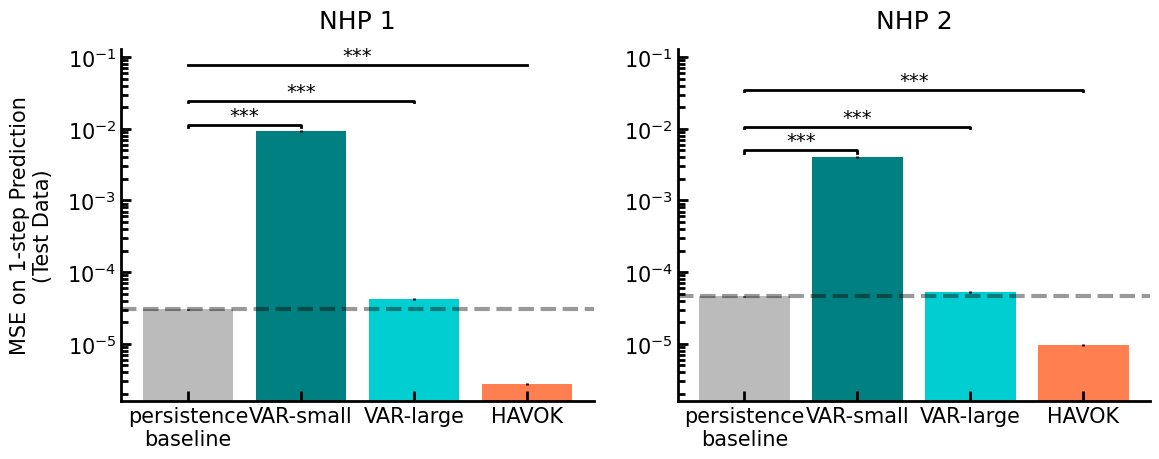

In [12]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
        ax = axs[i]   
        # bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-large', 'HAVOK']
        bars = [0, 1, 2, 3]
        # heights = np.array(mean_vals)
        bar_labels = ["persistence\nbaseline", "VAR-small", "VAR-large", "HAVOK"]
        heights = [mse_vals_pb[monkey][area].mean(),  mse_vals_VAR_small[monkey][area].mean(), mse_vals_VAR[monkey][area].mean(), mse_vals[monkey][area].mean()]
        se_vals = [mse_vals_pb[monkey][area].std()/np.sqrt(num_sessions[monkey]),  mse_vals_VAR_small[monkey][area].std()/np.sqrt(num_sessions[monkey]), mse_vals_VAR[monkey][area].std()/np.sqrt(num_sessions[monkey]), mse_vals[monkey][area].std()/np.sqrt(num_sessions[monkey])]
        ax.bar(bars, heights, color=model_colors, yerr=se_vals)
        # data = np.vstack((aic_vals_pb[monkey][area],  aic_vals_VAR_small[monkey][area], aic_vals_VAR[monkey][area], aic_vals[monkey][area]))
        # bplot = ax.boxplot(data.T, patch_artist=True)
        # for patch, color in zip(bplot['boxes'], model_colors):
        #     patch.set_facecolor(color)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
        ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_title(f"NHP {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"MSE on 1-step Prediction\n(Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        dh = 0.1
        gap = 1
        barh = 0.1
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals_VAR_small[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals_VAR[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=1.1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals[monkey][area], alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=2, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        
        ax.axhline(mse_vals_pb[monkey][area].mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "SI", "mse-prediction-avg.pdf"), bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(img_save_dir, "SI", "mse-prediction.pdf"), bbox_inches='tight', transparent=True)
plt.show()

## Prediction quality: combined monkeys

In [13]:
split_by_monkey = False
if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
    monkey_sessions = {monkey: [session for session in session_list if monkey in session] for monkey in monkeys}
    session_dicts = {monkey: {session: session_rets[session] for session in monkey_sessions[monkey]} for monkey in monkeys}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
else:
    monkeys = ['Combined']
    monkey_sessions = {'Combined': session_list}
    session_dicts = {'Combined': session_rets}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}

# areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
areas = ['all']

In [14]:
aic_vals = {}
aic_vals_pb = {}
aic_vals_VAR = {}
aic_vals_VAR_small = {}

mse_vals = {}
mse_vals_pb = {}
mse_vals_VAR = {}
mse_vals_VAR_small = {}

iterator = tqdm(total=len(session_list)*len(areas))

for monkey in monkeys:
    aic_vals[monkey] = {}
    aic_vals_pb[monkey] = {}
    aic_vals_VAR[monkey] = {}
    aic_vals_VAR_small[monkey] = {}

    mse_vals[monkey] = {}
    mse_vals_pb[monkey] = {}
    mse_vals_VAR[monkey] = {}
    mse_vals_VAR_small[monkey] = {}
    for area in areas:
        aic_vals[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_pb[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_VAR[monkey][area] = np.zeros(num_sessions[monkey])
        aic_vals_VAR_small[monkey][area] = np.zeros(num_sessions[monkey])

        mse_vals[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_pb[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_VAR[monkey][area] = np.zeros(num_sessions[monkey])
        mse_vals_VAR_small[monkey][area] = np.zeros(num_sessions[monkey])
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
        
            aic_vals[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val.mean()
            aic_vals_pb[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_pb.mean()
            aic_vals_VAR[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_VAR.mean()
            aic_vals_VAR_small[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].aic_val_VAR_small.mean()

            mse_vals[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val.mean()
            mse_vals_pb[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_pb.mean()
            mse_vals_VAR[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_VAR.mean()
            mse_vals_VAR_small[monkey][area][session_ind] = session_dicts[monkey][session]['results_dict'][area].mse_val_VAR_small.mean()

            iterator.update()
iterator.close()

figure3_data['combined_monkeys'] = dict(
    aic_vals=aic_vals,
    aic_vals_pb=aic_vals_pb,
    aic_vals_VAR=aic_vals_VAR,
    aic_vals_VAR_small=aic_vals_VAR_small,
    mse_vals=mse_vals,
    mse_vals_pb=mse_vals_pb,
    mse_vals_VAR=mse_vals_VAR,
    mse_vals_VAR_small=mse_vals_VAR_small
)

  0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
statistical_test = scipy.stats.wilcoxon
# statistical_test = scipy.stats.ttest_ind

In [16]:
model_colors = ['#BBBBBB', 'teal', 'darkturquoise', 'coral']

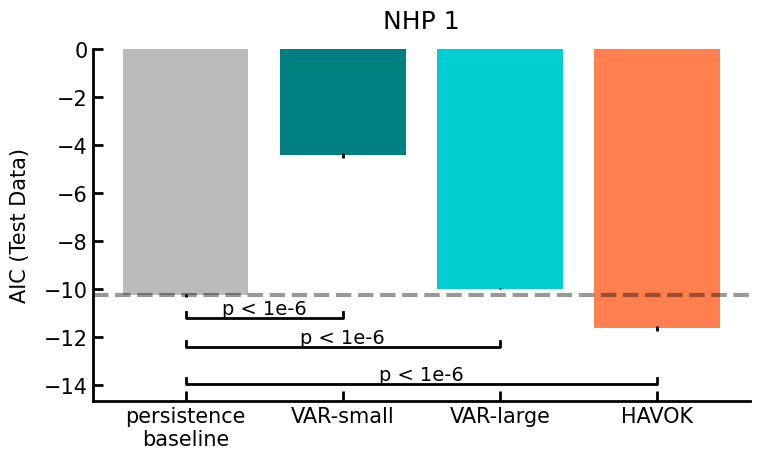

In [17]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
        # ax = axs[i]   
        # bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-large', 'HAVOK']
        bars = [0, 1, 2, 3]
        # heights = np.array(mean_vals)
        bar_labels = ["persistence\nbaseline", "VAR-small", "VAR-large", "HAVOK"]
        heights = [aic_vals_pb[monkey][area].mean(),  aic_vals_VAR_small[monkey][area].mean(), aic_vals_VAR[monkey][area].mean(), aic_vals[monkey][area].mean()]
        se_vals = [aic_vals_pb[monkey][area].std()/np.sqrt(num_sessions[monkey]),  aic_vals_VAR_small[monkey][area].std()/np.sqrt(num_sessions[monkey]), aic_vals_VAR[monkey][area].std()/np.sqrt(num_sessions[monkey]), aic_vals[monkey][area].std()/np.sqrt(num_sessions[monkey])]
        ax.bar(bars, heights, color=model_colors, yerr=se_vals)
        # data = np.vstack((aic_vals_pb[monkey][area],  aic_vals_VAR_small[monkey][area], aic_vals_VAR[monkey][area], aic_vals[monkey][area]))
        # bplot = ax.boxplot(data.T, patch_artist=True)
        # for patch, color in zip(bplot['boxes'], model_colors):
        #     patch.set_facecolor(color)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
        # ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_title(f"NHP {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"AIC (Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        dh = 0.05
        gap = 0.1
        barh = 0.02
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals_VAR_small[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals_VAR[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        p = statistical_test(aic_vals_pb[monkey][area], aic_vals[monkey][area], alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=False, ax=ax, it=1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)
        
        ax.axhline(aic_vals_pb[monkey][area].mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "aic-prediction.pdf"), bbox_inches='tight', transparent=True)
plt.show()

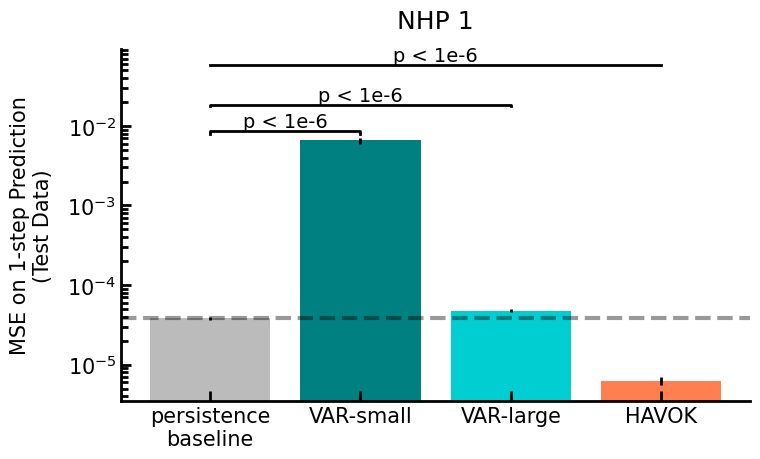

In [18]:
tick_fontsize = 15
title_fontsize = 18
ylabel_fontsize = 15
p_fontsize=14

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharey=True)
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
        # ax = axs[i]   
        # bar_labels = ['persistence\nbaseline', 'VAR-small', 'VAR-large', 'HAVOK']
        bars = [0, 1, 2, 3]
        # heights = np.array(mean_vals)
        bar_labels = ["persistence\nbaseline", "VAR-small", "VAR-large", "HAVOK"]
        heights = [mse_vals_pb[monkey][area].mean(),  mse_vals_VAR_small[monkey][area].mean(), mse_vals_VAR[monkey][area].mean(), mse_vals[monkey][area].mean()]
        se_vals = [mse_vals_pb[monkey][area].std()/np.sqrt(num_sessions[monkey]),  mse_vals_VAR_small[monkey][area].std()/np.sqrt(num_sessions[monkey]), mse_vals_VAR[monkey][area].std()/np.sqrt(num_sessions[monkey]), mse_vals[monkey][area].std()/np.sqrt(num_sessions[monkey])]
        ax.bar(bars, heights, color=model_colors, yerr=se_vals)
        # data = np.vstack((aic_vals_pb[monkey][area],  aic_vals_VAR_small[monkey][area], aic_vals_VAR[monkey][area], aic_vals[monkey][area]))
        # bplot = ax.boxplot(data.T, patch_artist=True)
        # for patch, color in zip(bplot['boxes'], model_colors):
        #     patch.set_facecolor(color)
        ax.set_xticks(bars)
        ax.set_xticklabels(bar_labels)
        ax.set_yscale('log')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        if j == 0:
            ax.set_title(f"NHP {i + 1}", fontsize=title_fontsize)
            
        if i == 0:
            ax.set_ylabel(f"MSE on 1-step Prediction\n(Test Data)", fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
        dh = 0.1
        gap = 1
        barh = 0.1
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals_VAR_small[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 1, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals_VAR[monkey][area], alternative='less').pvalue
        barplot_annotate_brackets(0, 2, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=1.1, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        p = statistical_test(mse_vals_pb[monkey][area], mse_vals[monkey][area], alternative='greater').pvalue
        barplot_annotate_brackets(0, 3, p, bars, heights, yerr=se_vals, scale_by_height=True, ax=ax, it=2, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
        
        ax.axhline(mse_vals_pb[monkey][area].mean(), linestyle='--', c='k', linewidth=3, alpha=0.4)
        
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "mse-prediction.pdf"), bbox_inches='tight', transparent=True)
plt.show()

## SAVE DATA

In [19]:
import pickle

with open(os.path.join(data_save_dir, 'figure3_prediction_quality.pkl'), 'wb') as handle:
    pickle.dump(figure3_data, handle, protocol=pickle.HIGHEST_PROTOCOL)